# Stanford Stats 191

## Introduction

This is a re-creation of the Stanford Stats 191 course (see https://web.stanford.edu/class/stats191/), using Python eco-system tools, instead of R.  This is lecture "Correlated errors"


## Initial Notebook Setup

```watermark ``` documents the current Python and package environment, ```black``` is my preferred Python formatter

In [1]:
%load_ext watermark

In [2]:
%load_ext lab_black

In [3]:
%matplotlib inline

All import got here (not all are used in this Notebook)

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.formula.api import rlm
from statsmodels.formula.api import mixedlm
from statsmodels.formula.api import wls

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

import datetime


import warnings

D:\Anaconda3\envs\ac5-py37\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


---------------

## Seasonal Variations

This is an example of a dataset where there is a  clear seasonal variation in the dataset.  

For each day of the year (e.g. 51st day of year), we plot the maximum temperature

One point I ignored was that for each day-number of each  month (e.g. 2nd of January), we get the maximum temperature all years, and the year in which that maximum occured.

However leap years have an extra day, so an observation that the maximum temperature for (say) 1st October will be plotted in a different place, depending if it occurred in 1996 or 1995.
I probably should have converted day of year into fraction of year (i.e. divide by 365 or 366, cdepending upon if the maximum occured in a non-leap or leap year)

In [5]:
names = ['X' + str(i) for i in range(1, 7)]
widths = [2, 3, 4, 4, 4, 5]
data = pd.read_fwf(
    '../data/paloalto.txt',
    skiprows=2,
    names=names,
    widths=widths,
)
data.head()

,X1,X2,X3,X4,X5,X6
0,1,1,56,48,68,1997
1,1,2,57,49,69,1996
2,1,3,55,48,72,1996
3,1,4,56,50,64,2001
4,1,5,56,49,66,2001


Note the technique to get day-of-year, via the ```datetime``` library

In [6]:
DAY_OF_YEAR = 7

#
doy = [
    datetime.date(ye, mo, da).timetuple()[DAY_OF_YEAR]
    for ye, mo, da in zip(
        data['X6'], data['X1'], data['X2']
    )
]
doy[0:10], doy[-10:]

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [356, 357, 358, 359, 360, 361, 362, 363, 364, 365])

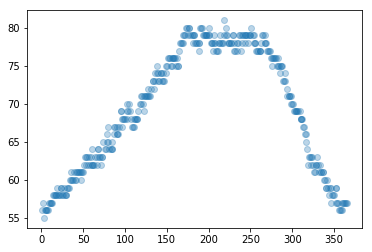

In [7]:
_ = plt.plot(doy, data['X3'], 'o', alpha=0.3)

----------------


## Share Price Dataset 

In this dataset, there appear to be patterns, but these might be due to noise.

### Read, Explore, and Clean Dataset

In [8]:
data2 = pd.read_csv('../data/nasdaq_2011.csv')
data2.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2011-12-30,55.87,56.12,55.82,55.83,21832400,55.83
1,2011-12-29,55.68,56.03,55.50,55.99,28077900,55.99
2,2011-12-28,56.17,56.26,55.44,55.59,38180100,55.59
3,2011-12-27,55.99,56.42,55.93,56.24,21443500,56.24
4,2011-12-23,55.71,56.08,55.58,56.08,26594600,56.03


We chcek the data types of our columns;  as we feared, the date-time column is still a string.  We convert these to date-times using ```pandas```

In [9]:
data2.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume         int64
Adj Close    float64
dtype: object

In [10]:
data2['Date'] = pd.to_datetime(data2['Date'])

We check our first value for being a date-time, and check the data types (all good, now)

In [11]:
data2['Date'].iloc[0]

Timestamp('2011-12-30 00:00:00')

In [12]:
data2.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume                int64
Adj Close           float64
dtype: object

### Plot Dataset
We now plot the dataset.   Note the ```autofmt_xdate()``` to get X axis labels that don't overlap 

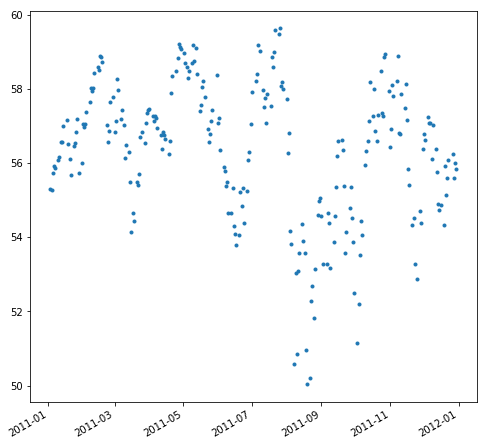

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

fig.autofmt_xdate()

ax.plot(data2['Date'], data2['Close'], '.')

### Perform Autocorrelation

The ```acf``` function returns (in its default form) an array of autocorrelation results, that show how strongly correlated a daily Close value is asso0ciated withe previous market Close values

In [14]:
res = acf(data2['Close'])
res[0:5]

array([1.        , 0.90503463, 0.82014408, 0.72000704, 0.64544738])

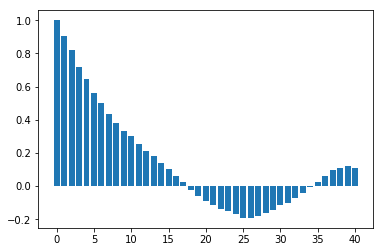

In [15]:
_ = plt.bar(x=range(len(res)), height=res)

We can also ask for the Confidence Interval (CI), that the correlation we see are unlikely to have happened by chance.

There is a curious inconsistency, in that the upper and lower CI bands are reported by the ```acf``` function as being centered on the autocorrrelation curve. but the ```statsmodels``` ```plot_acf``` draws them centered on the X axis.   I have shown both forms below.

In [16]:
res = acf(data2['Close'], alpha=0.05)
res[0].shape, res[1].shape

((41,), (41, 2))

In [17]:
yerr_lo = [x[0] for x in res[1]]
yerr_hi = [x[1] for x in res[1]]

In [18]:
res[1][0:5]

array([[1.        , 1.        ],
       [0.78156851, 1.02850076],
       [0.61960471, 1.02068345],
       [0.47358623, 0.96642786],
       [0.36880973, 0.92208503]])

Centering the CI bands on the X axis

Text(0.5, 1.0, 'Autocorrelation Graph')

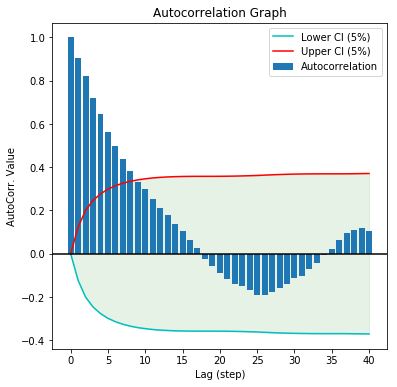

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.bar(
    x=list(range(len(res[0]))),
    height=res[0],
    label='Autocorrelation',
)
ax.plot(
    list(range(len(res[0]))),
    yerr_lo - res[0],
    'c-',
    label='Lower CI (5%)',
)
ax.plot(
    list(range(len(res[0]))),
    yerr_hi - res[0],
    'r-',
    label='Upper CI (5%)',
)

ax.fill_between(
    list(range(len(res[0]))),
    yerr_hi - res[0],
    yerr_lo - res[0],
    color='green',
    alpha=0.1,
)

ax.axhline(0, color='k')
ax.legend(loc='best')
ax.set_xlabel('Lag (step)')
ax.set_ylabel('AutoCorr. Value')
ax.set_title('Autocorrelation Graph')

Centering the CI bands on the autocorrelation values

Text(0.5, 1.0, 'Autocorrelation Graph')

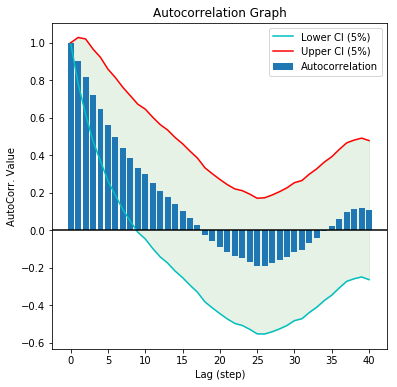

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.bar(
    x=list(range(len(res[0]))),
    height=res[0],
    label='Autocorrelation',
)
ax.plot(
    list(range(len(res[0]))),
    yerr_lo,
    'c-',
    label='Lower CI (5%)',
)
ax.plot(
    list(range(len(res[0]))),
    yerr_hi,
    'r-',
    label='Upper CI (5%)',
)

ax.fill_between(
    list(range(len(res[0]))),
    yerr_hi,
    yerr_lo,
    color='green',
    alpha=0.1,
)

ax.axhline(0, color='k')
ax.legend(loc='best')
ax.set_xlabel('Lag (step)')
ax.set_ylabel('AutoCorr. Value')
ax.set_title('Autocorrelation Graph')

Finally, using the ```statsmodels``` build=in function

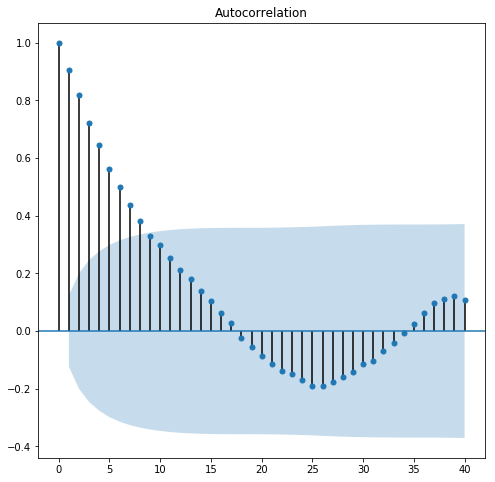

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
_ = plot_acf(data2['Close'], ax=ax, lags=40)

### Transforming Dataset

If we look at the log of the ratio of daily Close values (lagged by one), we get a plot where there appear to be no discernable patterns

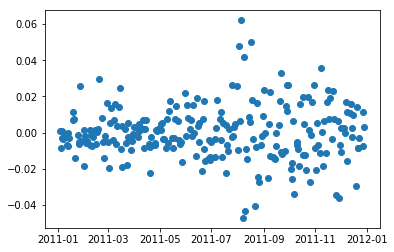

In [22]:
close = list(data2['Close'])
log_return = [
    np.log(a / b) for a, b in zip(close[1:], close[:-1])
]

_ = plt.plot(data2['Date'][1:], log_return, 'o')

Now, when we perform an auto-correlation, we find only the lag=0 spike. The ```plot_acf``` function shows no significant (at 95% level) auto-correlations.

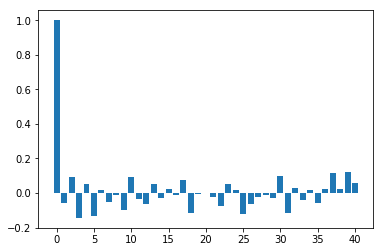

In [23]:
res2 = acf(log_return)
_ = plt.bar(x=list(range(len(res2))), height=res2)

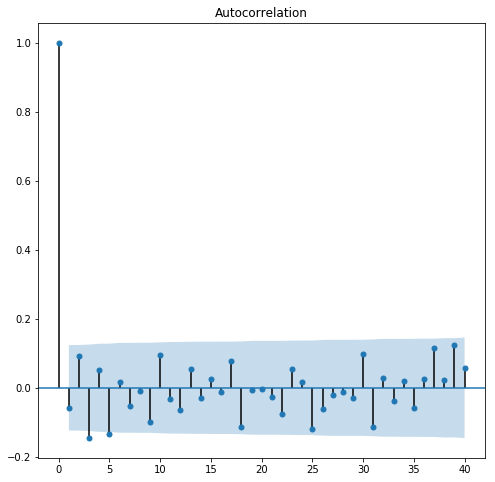

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
_ = plot_acf(log_return, ax=ax, lags=40)

### Random (non-correlated) Noise

For comparison, we show the autocorrelation of random Gaussian noise.

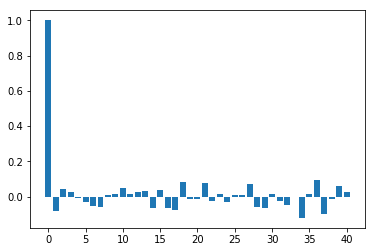

In [25]:
res3 = acf(np.random.normal(0, 1, len(data2['Close'])))
_ = plt.bar(x=list(range(len(res3))), height=res3)

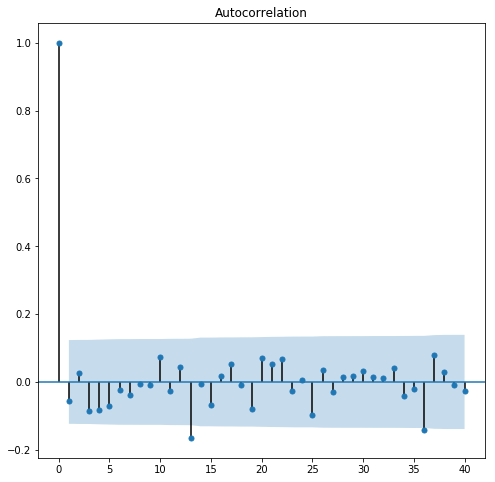

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))
_ = plot_acf(
    np.random.normal(0, 1, len(data2['Close'])),
    ax=ax,
    lags=40,
)

---------------

###  Auto-correlation of Residuals

As well as having the raw data be correlated with past values, the noise (error) at an observation could also be correlated with previous noise values.  We look at a dataset, with a linear trend, but also with yearly correlation in the residuals

#### Read, Clean, and Plot dataset

In [27]:
data3 = pd.read_csv('../data/expenditure.txt', sep='\t')
data3.head()

,Year,Quarter,Expenditure,Stock
0,1952,1,214.6,159.3
1,1952,2,217.7,161.2
2,1952,3,219.6,162.8
3,1952,4,227.2,164.6
4,1953,1,230.9,165.9


Remove trailing space in column names

In [28]:
data3.columns

Index(['Year ', 'Quarter ', 'Expenditure ', 'Stock '], dtype='object')

In [29]:
new_names = [s.strip() for s in data3.columns]
new_names

['Year', 'Quarter', 'Expenditure', 'Stock']

In [30]:
data3.columns = new_names

Plot ```Stock``` against ```Expenditure```

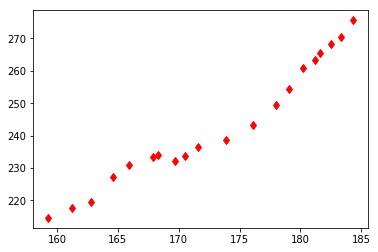

In [31]:
_ = plt.plot(data3['Stock'], data3['Expenditure'], 'rd')

#### Perform OLS Linear Fit

Perform an OLS fit of a linear model, and plot residuals (which are clearly __not__ randomly distributed)

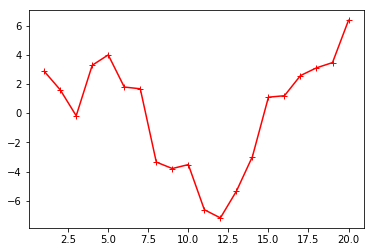

In [32]:
res4 = ols('Expenditure ~ Stock', data=data3).fit()
_ = plt.plot(
    range(1, len(res4.resid) + 1), res4.resid, 'r+-'
)

Plot the auto-correlation of the residuals 

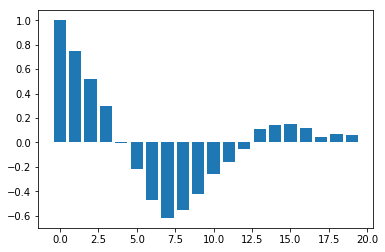

In [33]:
res5 = acf(res4.resid)
_ = plt.bar(x=list(range(len(res5))), height=res5)

This link from Matlab (https://www.mathworks.com/help/signal/ug/confidence-intervals-for-sample-autocorrelation.html)  shows one way to determine the Confidence Intervals: essentially determining the CI levels for a Gaussian noise, mean zero, and standard deviation (1/L), where L is the maximum lag.  This appears to be CI band also used by the ```R``` examples shown in the ```statsmodels``` lecture notes.  I must say I do not understand the CI bands show by ```plot_acf```.

In any event, there does appear to be some statistically significant autocorrelation.

In [34]:
ci_normal = stats.norm.ppf(0.025), stats.norm.ppf(0.975)
ci_auto = ci_normal / np.sqrt(len(data3))
ci_auto

array([-0.43826127,  0.43826127])

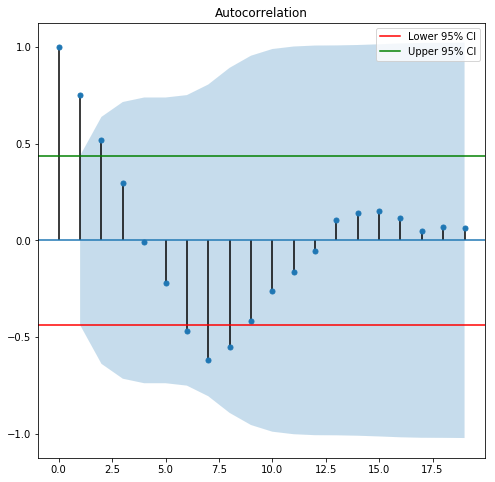

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))
_ = plot_acf(res4.resid, ax=ax, alpha=0.05)

ax.axhline(ci_auto[0], color='r', label='Lower 95% CI')
ax.axhline(ci_auto[1], color='g', label='Upper 95% CI')
ax.legend(loc='best')

--------------------
## AR(1)

In this section, we explicitly build a model, where the noise for an observation depends upon Gaussian noise __plus__ a constant times the noise from the previous observation

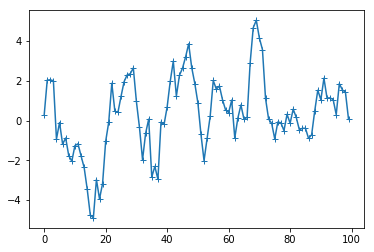

In [36]:
nsample = 100
rho = 0.9
mu = 1.0
sigma = 1.0

error = [np.random.normal(0, sigma)]

for i in range(1, nsample):
    error.append(
        rho * error[i - 1] + np.random.normal(0, sigma)
    )
# end for

_ = plt.plot(range(len(error)), error, '-+')

Plotting the autocorrelation values shows the statistically significant values

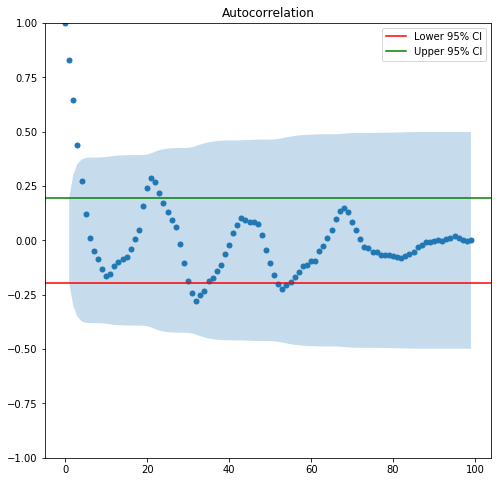

In [37]:
ci_normal = stats.norm.ppf(0.025), stats.norm.ppf(0.975)
ci_auto = ci_normal / np.sqrt(len(error))
ci_auto

fig, ax = plt.subplots(figsize=(8, 8))
_ = plot_acf(error, ax=ax, alpha=0.05, use_vlines=False)

ax.set_ylim(-1, 1)
ax.axhline(ci_auto[0], color='r', label='Lower 95% CI')
ax.axhline(ci_auto[1], color='g', label='Upper 95% CI')
ax.legend(loc='best')

We can also use the ```statsmodels``` random process functions/objects.  Here we have no moving average, so the ```ma``` parameter is just 1.  In ```statsmodels```, the weight of the previous noise value is negated (in ```ar```)

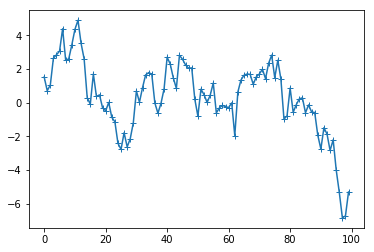

In [38]:
ar = np.r_[1, -0.9]
ma = np.r_[1]
ar, ma

arma_process = sm.tsa.ArmaProcess(ar, ma)

y = arma_process.generate_sample(100)
_ = plt.plot(range(len(y)), y, '-+')

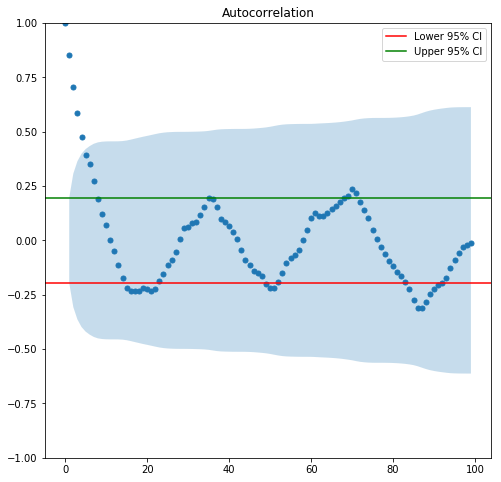

In [39]:
ci_normal = stats.norm.ppf(0.025), stats.norm.ppf(0.975)
ci_auto = ci_normal / np.sqrt(len(y))
ci_auto

fig, ax = plt.subplots(figsize=(8, 8))
_ = plot_acf(y, ax=ax, alpha=0.05, use_vlines=False)

ax.set_ylim(-1, 1)
ax.axhline(ci_auto[0], color='r', label='Lower 95% CI')
ax.axhline(ci_auto[1], color='g', label='Upper 95% CI')
ax.legend(loc='best')

------
## Impact of Autocorrelated Noise

As can be seen below, the impact of the autocorrelated (AR(1)) noise is to broaden the probability density curve for the estimate of the mean.  This means that we would expect to see estimates far from the true mean, leading us to mistakenly reject the Null Hypothesis (here, mean is zero)


For 1000 trials, we create 100 samples of true memoryless noise, and autocorrelated noise (AR(1)), and take the mean of each.  We then plot the histogram of mean values seen.

Text(0.5, 0, 'Estimate of Mean')

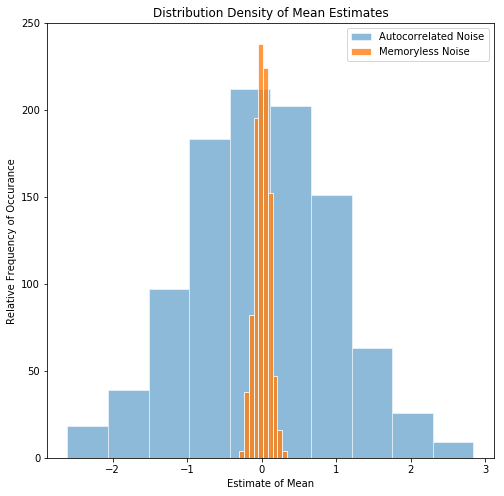

In [40]:
nsample = 100
rho = 0.9
mu = 1.0
sigma = 1.0

means1 = []
means2 = []

ntrials = 1000
for i in range(ntrials):
    #  error1 holds autocorrelated noise
    error1 = [np.random.normal(0, sigma)]

    for i in range(1, nsample):
        error1.append(
            rho * error1[i - 1] + np.random.normal(0, sigma)
        )
    # end for

    # error2 holds memoryless noise
    error2 = np.random.normal(0, sigma, 100)

    means1.append(np.mean(error1))
    means2.append(np.mean(error2))
# end for


fig, ax = plt.subplots(figsize=(8, 8))
h1 = ax.hist(
    means1,
    alpha=0.5,
    label='Autocorrelated Noise',
    edgecolor='w',
)
h2 = ax.hist(
    means2,
    alpha=0.8,
    label='Memoryless Noise',
    edgecolor='w',
)
ax.legend(loc='best')
ax.set_title('Distribution Density of Mean Estimates')
ax.set_ylabel('Relative Frequency of Occurance')
ax.set_xlabel('Estimate of Mean')

------
## Autocorrelation of Daily Temperature

As an exercise (__not__ in STATS191) I decided to look at weather data

### Load, Explore, and Clean Dataset

In [41]:
wdata = pd.read_csv('../data/daily-min-temperatures.txt')
wdata.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [42]:
wdata.dtypes

Date     object
Temp    float64
dtype: object

Convert ```string``` dates into ```datetime64``` objects

In [43]:
wdata['Date'] = pd.to_datetime(wdata['Date'])
wdata.dtypes

Date    datetime64[ns]
Temp           float64
dtype: object

### Plot Dataset

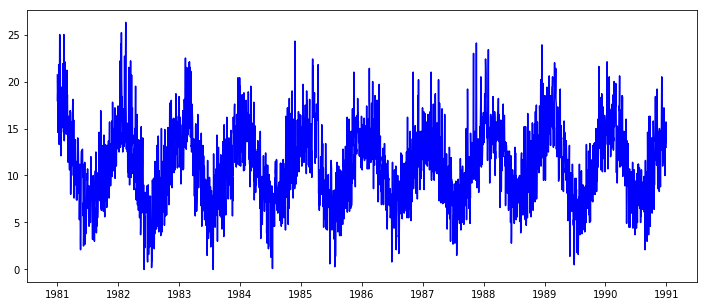

In [44]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(wdata['Date'], wdata['Temp'], 'b-')

Redo plot, but with a better grid

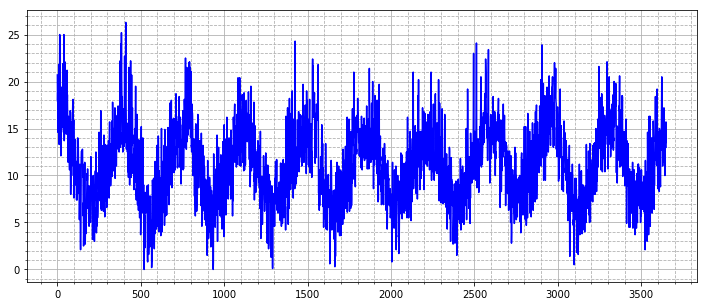

In [45]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(list(range(len(wdata))), wdata['Temp'], 'b-')
ax.grid(axis='both', which='major')
ax.grid(axis='both', which='minor', linestyle='--')
ax.minorticks_on()

Clearly the temperature now strongly correlates with what it was a year ago, almost out to 10 years ago

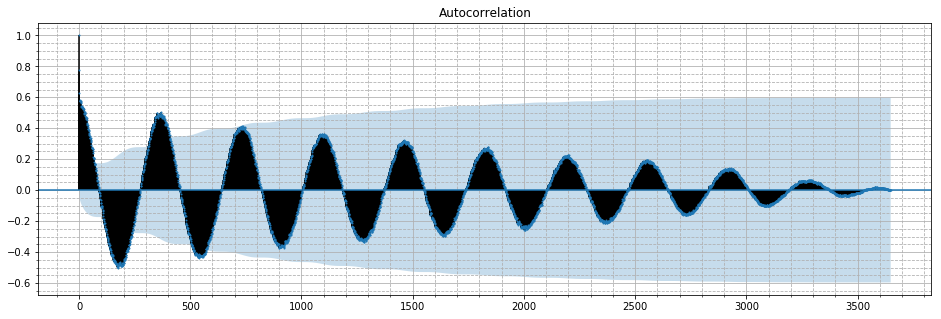

In [46]:
fig, ax = plt.subplots(figsize=(16, 5))

_ = plot_acf(wdata['Temp'], ax=ax, markersize=1)
ax.grid(axis='both', which='major')
ax.grid(axis='both', which='minor', linestyle='--')
ax.minorticks_on()

Focussing in on a two year period, we see the expected autocorrelation in more detail.

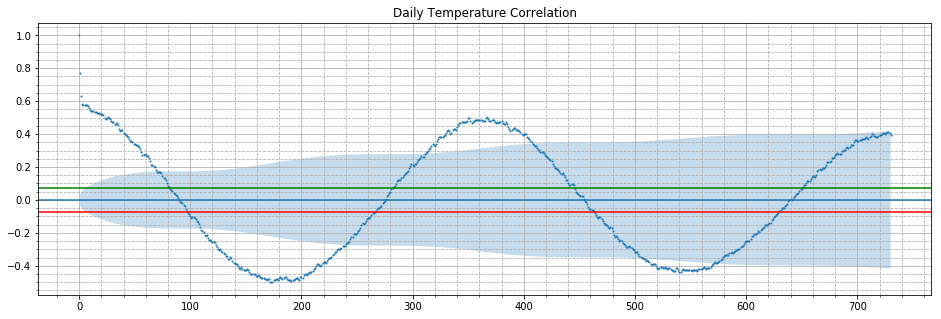

In [47]:
ci_normal = stats.norm.ppf(0.025), stats.norm.ppf(0.975)
ci_auto = ci_normal / np.sqrt(365 * 2)
ci_auto


fig, ax = plt.subplots(figsize=(16, 5))

_ = plot_acf(
    wdata['Temp'],
    ax=ax,
    markersize=1,
    lags=365 * 2,  # two years
    use_vlines=False,
    title='Daily Temperature Correlation',
)

ax.grid(axis='both', which='major')
ax.grid(axis='both', which='minor', linestyle='--')
ax.axhline(ci_auto[0], color='r', label='Lower 95% CI')
ax.axhline(ci_auto[1], color='g', label='Upper 95% CI')
ax.axhline(0)
ax.minorticks_on()

-----
## Environment


In [48]:
%watermark -h -iv
%watermark

scipy       1.1.0
numpy       1.15.4
matplotlib  3.0.2
statsmodels 0.9.0
seaborn     0.9.0
pandas      1.0.0
host name: DESKTOP-SODFUN6
2020-04-16T14:27:32+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


In [49]:
sm.show_versions()


INSTALLED VERSIONS
------------------
Python: 3.7.1.final.0

Statsmodels

Installed: 0.9.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\statsmodels)

Required Dependencies

cython: 0.29.2 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\Cython)
numpy: 1.15.4 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\numpy)
scipy: 1.1.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\scipy)
pandas: 1.0.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\pandas)
    dateutil: 2.7.5 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\dateutil)
patsy: 0.5.1 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\patsy)

Optional Dependencies

matplotlib: 3.0.2 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\matplotlib)
    backend: module://ipykernel.pylab.backend_inline 
cvxopt: Not installed
joblib: 0.13.2 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\joblib)

Developer Tools

IPython: 7.2.0 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\IPython)
    jinja2: 2.10.1 (D:\Anaconda3\envs\ac5-py37\lib\site-packages\jinja2)
sphinx: